In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
test.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [5]:
print('Size of training set: {} rows and {} columns'.format(*train.shape))
print('Size of testing set: {} rows and {} columns'.format(*test.shape))

Size of training set: 4209 rows and 378 columns
Size of testing set: 4209 rows and 377 columns


In [6]:
cols = [c for c in train.columns if 'X' in c]
print('Number of features: {}'.format(len(cols)))
print('Feature types:')
train[cols].dtypes.value_counts()

Number of features: 376
Feature types:


int64     368
object      8
dtype: int64

**Check for null and unique values**

In [7]:
usable_columns = list(set(train.columns) - set(['ID', 'y']))
y_train = train['y'].values
id_test = test['ID'].values

x_train = train[usable_columns]
x_test = test[usable_columns]


In [8]:
def check_missing_values(df):
    if df.isnull().any().any():
        print('There are missing values in the dataframe')
    else:
        print('There are no missing values in the dataframe')

In [9]:
check_missing_values(x_train)
check_missing_values(x_test)

There are no missing values in the dataframe
There are no missing values in the dataframe


**label encoder**

In [13]:
#Label Encoding the categorical values 
for column in usable_columns:
    cardinality = len(np.unique(x_train[column]))
    if cardinality == 1:
        x_train.drop(column, axis=1) 
        # value is useless so we drop it
        x_test.drop(column, axis=1)
    if cardinality > 2: # Column is categorical
        mapper = lambda x: sum([ord(digit) for digit in x])
        x_train[column] = x_train[column].apply(mapper)
        x_test[column] = x_test[column].apply(mapper)
x_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,X22,X27,X249,X79,X314,X285,X52,X151,X275,X10,X244,X197,X274,X69,X122,X384,X125,X331,X265,X76,X351,X301,X26,X110,X272,X349,X146,X169,X225,X163,X80,X231,X339,X361,X280,X260,X147,X83,X227,X363,...,X123,X271,X264,X158,X174,X295,X334,X166,X299,X185,X112,X278,X129,X216,X307,X178,X357,X168,X6,X48,X203,X62,X54,X358,X56,X287,X345,X255,X237,X332,X106,X377,X19,X297,X329,X277,X306,X258,X215,X375
0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,106,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0
1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,106,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,108,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,100,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
print('Feature:')
x_train[cols].dtypes.value_counts()

Feature:


int64    376
dtype: int64

In [17]:
n_comp = 15
pca = PCA(n_components = n_comp,random_state = 425)
pca2_results_train = pca.fit_transform(x_train)
pca2_results_test = pca.transform(x_test)

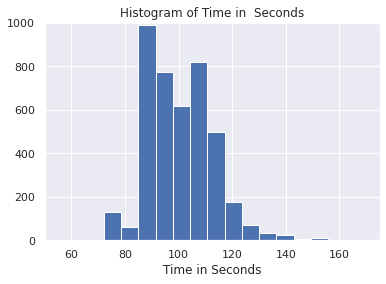

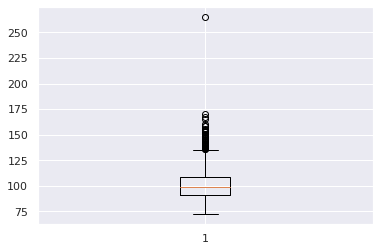

In [24]:
plt.hist(train.y, bins = 30)
plt.xlabel('Time in Seconds')
plt.title('Histogram of Time in  Seconds')
plt.grid(True)
plt.axis([50,175, 0,1000])
plt.show()

p = plt.boxplot(train.y)
plt.show()

**XGBoost**

In [18]:
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [25]:
x_train,x_val,y_train,y_val = train_test_split(pca2_results_train, y_train, test_size=0.2, random_state=4242)


In [27]:
d_train = xgb.DMatrix(x_train,label = y_train)
d_val = xgb.DMatrix(x_val,label = y_val)
d_test = xgb.DMatrix(pca2_results_test)

In [28]:
params = {}
params['objective'] = 'reg:linear'
params['eta'] = 0.02
params['max_depth'] = 4

def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)
watchlist = [(d_train, 'train'), (d_val, 'valid')]
clf = xgb.train(params, d_train,  1000, watchlist, early_stopping_rounds=50, 
 feval=xgb_r2_score, maximize=True, verbose_eval=10)

[05:59:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:99.1484	valid-rmse:98.263	train-r2:-58.353	valid-r2:-67.6375
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 50 rounds.
[10]	train-rmse:81.2761	valid-rmse:80.364	train-r2:-38.8838	valid-r2:-44.9097
[20]	train-rmse:66.7133	valid-rmse:65.7777	train-r2:-25.8718	valid-r2:-29.7567
[30]	train-rmse:54.8646	valid-rmse:53.8977	train-r2:-17.1742	valid-r2:-19.6501
[40]	train-rmse:45.2369	valid-rmse:44.2292	train-r2:-11.3554	valid-r2:-12.9059
[50]	train-rmse:37.4325	valid-rmse:36.3737	train-r2:-7.45996	valid-r2:-8.40495
[60]	train-rmse:31.1228	valid-rmse:30.0205	train-r2:-4.8483	valid-r2:-5.40644
[70]	train-rmse:26.0519	valid-rmse:24.9005	train-r2:-3.09778	valid-r2:-3.40754
[80]	train-rmse:21.9913	valid-rmse:20.8068	train-r2:-1.91994	valid-r2:-2.07746
[90]	train-rmse:18.7784	va

**Predict test_df using XGBoost**

In [29]:
p_test = clf.predict(d_test)

In [30]:
sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = p_test
sub.to_csv('test_df.csv', index = False)
sub.head()

,ID,y
0,1,79.169426
1,2,94.651009
2,3,79.888870
3,4,76.194939
4,5,112.719109
